# Eurovision voting - Data wrangling

## Introduction

This notebook gathers and prepares the data needed for the model used later on.

In [33]:
# Set up
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry
import pathlib

pd.options.mode.chained_assignment = None  # default='warn'
DATAPATH = pathlib.Path().resolve().parent / "data"

## Voting data

Analysing eurovision voting patterns first of all requires some data on each countries voting in each year.

### 1. Initial cleaning

To start, we will use [this data](https://www.kaggle.com/datasets/datagraver/eurovision-song-contest-scores-19752019), which can be found in the data directory of this repo.

Lets load in the data and see what we are working with:

In [34]:
df_input = pd.read_excel(DATAPATH / "eurovision_voting_scores_1975_2019.xlsx")
df_input.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
0,1975,f,1975f,J,Belgium,Belgium,0,x
1,1975,f,1975f,J,Belgium,Finland,0,NaN
2,1975,f,1975f,J,Belgium,France,2,NaN
3,1975,f,1975f,J,Belgium,Germany,0,NaN
4,1975,f,1975f,J,Belgium,Ireland,12,NaN


The voting system [significantly changed](https://en.wikipedia.org/wiki/Voting_at_the_Eurovision_Song_Contest) from 1998 onwards so we will get just the finals data from 1998 onwards.

In [35]:
df = df_input[df_input['Year'] > 1997]
df = df.loc[df['(semi-) final'] == 'f']
df = df.drop_duplicates()
df.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
10216,1998,f,1998f,J,Belgium,Belgium,0,x
10217,1998,f,1998f,J,Belgium,Croatia,5,NaN
10218,1998,f,1998f,J,Belgium,Cyprus,2,NaN
10219,1998,f,1998f,J,Belgium,Estonia,0,NaN
10220,1998,f,1998f,J,Belgium,F.Y.R. Macedonia,0,NaN


We need to clean up some of these columns and standardise things by removing white space and putting all names in lower case to prevent any mismatches later on. Furthermore, a deeper dive into the country names shows the inconsistencies which need resolving.

In [36]:
# remove white space from countries
df['To country'] = df['To country'].str.strip()
df['From country'] = df['From country'].str.strip()

# lower case
df['To country'] = df['To country'].str.lower()
df['From country'] = df['From country'].str.lower()

# tidy country names: fix typos, fill whitespace, rename
replace_list = [['-', ' '],
                ['&', 'and'], 
                ['netherands', 'netherlands'],
                ['f.y.r. macedonia', 'north macedonia'], 
                ['russia', 'russian federation'], 
                ['the netherlands', 'netherlands'], 
                ['czech republic', 'czechia'],
                ['serbia and montenegro', 'yugoslavia'],
                ['moldova', 'moldova, republic of']] 

for replacements in replace_list: 
  df['To country'] = df['To country'].str.replace(
      replacements[0], replacements[1], regex=True
    )
  df['From country'] = df['From country'].str.replace(
      replacements[0], replacements[1], regex=True
    )

countries = [df['From country'], df['To country']]
countries = np.sort(np.unique(countries))

For consistency with other data sets, we want to convert the country names to ISO alpha-2 codes. We will use the [pycountry](https://pypi.org/project/pycountry/) package to do this.

In [37]:
# Get country codes
country_codes = []
for country in countries:
    try:
        country_codes.append(pycountry.countries.get(name=country).alpha_2)
    except:
        country_codes.append('NaN')

# convert list to dictionary
country_codes_dict = dict(zip(countries, country_codes))

# print those NaN, who did not match to a country code
for key, value in country_codes_dict.items():
    if value == 'NaN':
        print('Missing code: ' + key)

Missing code: yugoslavia


We need to clean up that missing country code. There are also some geopolitical changes we need to take into consideration with the data:
Geopolitical changes: 
- Macedonia
  - FYR Macedonia between 1944 and 2018
  - North Macedonia 2019 onwards
  - So we are treating them as the same country
- Serbia and Montenegro
  - Existed from 1992 to 2006
  - Then separated into 2 countries 
  - So we are treating these as 2 separate instances

In [38]:
# Add 'serbia and montenegro' or 'yugoslavia' code
country_codes_dict.update({"yugoslavia": "YU"})

# We are saving the country_code as a pickle for convenience for other data curation pipelines
# Add other country names which could realistically be included
country_codes_dict.update({"serbia and montenegro": "YU"})
country_codes_dict.update({"czech republic": "CZ"})
country_codes_dict.update({'f.y.r. macedonia': 'MK'})
country_codes_dict.update({'russia': 'RU'})
country_codes_dict.update({'the netherlands': 'NL'})
country_codes_dict.update({'moldova': 'MD'})

# get the country codes as a list
country_codes = list(np.unique(list(country_codes_dict.values())))

# get the country codes as a list
country_codes = list(country_codes_dict.values())

Because we have a dictionary of the corresponding country names for each country code, we can replace the country names with the codes and perform merges with other datasets later using the country code dictionary.

In [39]:
# replace the to country with the country code
df['To country'] = df['To country'].map(country_codes_dict)
df['From country'] = df['From country'].map(country_codes_dict)
df.head()

,Year,(semi-) final,Edition,Jury or Televoting,From country,To country,Points,Duplicate
10216,1998,f,1998f,J,BE,BE,0,x
10217,1998,f,1998f,J,BE,HR,5,NaN
10218,1998,f,1998f,J,BE,CY,2,NaN
10219,1998,f,1998f,J,BE,EE,0,NaN
10220,1998,f,1998f,J,BE,MK,0,NaN


### 2. Calculating the voting scores

History of Voting System

The Eurovision voting system has changed significantly over time. For the complete history see [here](Information about how voting changed over time: https://eurovisionworld.com/esc/voting-systems-in-eurovision-history). For this reason we only focus on scores from 1998 onwards.

Before 2016, the jury and tele vote were reported as a combined score (50:50 split). After we get them reported individually (for transparency).

Since we treating 1..12 as ordered data, we can't simply get the average of the two as this will results in 0.5 scores. Instead we need to refactor the post-2016 scores into one outcome (combined tele+jury -> refactored to : 12, 10, 8, 7, 6, 5, 4, 3, 2, 1).

Before 2016, the jury and tele vote were reported as a combined score:

In [40]:
df2 = df.loc[df['Year'] < 2016]
df_to_2016 = df2.pivot(index=['Year', 'From country'], columns=['To country'], 
                       values='Points')
df_to_2016 = df_to_2016
df_to_2016.head()

To country         AL  AM  AT  AU  AZ  BA   BE  BG  BY   CH  ...   RO  RS  RU  \
Year From country                                            ...                
1998 BE           NaN NaN NaN NaN NaN NaN  0.0 NaN NaN  0.0  ...  0.0 NaN NaN   
     CH           NaN NaN NaN NaN NaN NaN  4.0 NaN NaN  0.0  ...  0.0 NaN NaN   
     CY           NaN NaN NaN NaN NaN NaN  6.0 NaN NaN  0.0  ...  0.0 NaN NaN   
     DE           NaN NaN NaN NaN NaN NaN  4.0 NaN NaN  0.0  ...  0.0 NaN NaN   
     EE           NaN NaN NaN NaN NaN NaN  6.0 NaN NaN  0.0  ...  0.0 NaN NaN   

To country           SE   SI   SK  SM    TR  UA  YU  
Year From country                                    
1998 BE             0.0  0.0  0.0 NaN   0.0 NaN NaN  
     CH             0.0  0.0  0.0 NaN   0.0 NaN NaN  
     CY             0.0  0.0  0.0 NaN   0.0 NaN NaN  
     DE             0.0  0.0  0.0 NaN  12.0 NaN NaN  
     EE            12.0  0.0  0.0 NaN   0.0 NaN NaN  

[5 rows x 46 columns]

Now lets calculate the combined score for each country post 2016, and then convert to a 1..12 scale.

In [41]:
# create new df with column for each country
df_from_2016 = pd.DataFrame(columns=['Year', 'From country'] + country_codes)
df_from_2016 = df_from_2016.set_index(['Year', 'From country'])

# for each year, and country, get the total points
for i in range(2016, 2022):
    subset = df.loc[(df['Year'] == i)] 
    for country in subset['From country'].unique():  
        
        subset_country = subset.loc[subset['From country'] == country,]
        subset_country = subset_country.pivot(index=['Jury or Televoting'], 
                                                columns=['To country'], 
                                                values='Points')

        # if the number of rows > 0, then add the total row
        if len(subset_country.index) > 0:

            # Add row for total points
            # - 50:50 split between jury and televote so can half the points
            # - this results in half points, and multiple performers getting 
            # - the same score but scales with years prior
            subset_country.loc['Total'] = subset_country.sum()

            # Add row for the order rank of the countries        
            s = subset_country.loc['Total']
            subset_country.loc['Rank'] = [sorted(s, reverse=True).index(val) + 1 for val in s] 

            # Map 1-10 Rank to 1-8, 10, 12 Points
            subset_country.loc['Points'] = subset_country.loc['Rank'].map({1: 12, 2: 10, 3: 8, 4: 7, 5: 6, 6: 5, 7: 4, 8: 3, 9: 2, 10: 1})
            subset_country.loc['Points'] = subset_country.loc['Points'].fillna(0)

            subset_country = subset_country.loc[['Points'],:]
            subset_country['Year'] = i
            subset_country['From country'] = country

            subset_country = subset_country.set_index(['Year', 'From country'])

            # order columns
            subset_country = subset_country.reindex(columns=df_from_2016.columns)
            df_from_2016 = pd.concat([df_from_2016, subset_country])

# remove duplicated rows
df_from_2016 = df_from_2016.drop_duplicates()

df_from_2016.head()

AL   AD   AM    AU   AT   AZ  BY    BE   BA    BG  ...  \
Year From country                                                     ...   
2016 AL           NaN  NaN  0.0  12.0  0.0  0.0 NaN   0.0  NaN   7.0  ...   
     AM           NaN  NaN  NaN   3.0  2.0  0.0 NaN   2.0  NaN   4.0  ...   
     AU           NaN  NaN  0.0   NaN  0.0  0.0 NaN  12.0  NaN  10.0  ...   
     AT           NaN  NaN  0.0  12.0  NaN  0.0 NaN   1.0  NaN   1.0  ...   
     AZ           NaN  NaN  0.0   5.0  0.0  NaN NaN   0.0  NaN   8.0  ...   

                    TR    UA   GB   YU   YU   CZ  MK    RU   NL  MD  
Year From country                                                    
2016 AL            NaN   5.0  3.0  NaN  NaN  0.0 NaN   8.0  0.0 NaN  
     AM            NaN   5.0  0.0  NaN  NaN  0.0 NaN   8.0  0.0 NaN  
     AU            NaN   7.0  5.0  NaN  NaN  0.0 NaN   1.0  0.0 NaN  
     AT            NaN   6.0  0.0  NaN  NaN  0.0 NaN   7.0  3.0 NaN  
     AZ            NaN  10.0  0.0  NaN  NaN  0.0 NaN  12.0  0.0 NaN  

[5 rows x 55 columns]

So, due to the combination of jury and televoting, some ties occur in the post-2016 scaling, But the number of zeroes should always be 16 ish (26 performing counties - 10 votes, will be less in cases with lots of ties for scores of  1 or 2, or if the country itself performed).

Lets clean that up and join the pre and post 2016 datasets. 

In [42]:
df_from_2016.eq(0).sum(axis=1)
df_all = df_from_2016.add(df_to_2016, fill_value=0)
df_all.head()

AD  AL  AM  AT  AU  AZ   BA   BE  BG  BY  ...  RU  RU  \
Year From country                                             ...           
1998 BE            NaN NaN NaN NaN NaN NaN  NaN  0.0 NaN NaN  ... NaN NaN   
     CH            NaN NaN NaN NaN NaN NaN  NaN  4.0 NaN NaN  ... NaN NaN   
     CY            NaN NaN NaN NaN NaN NaN  NaN  6.0 NaN NaN  ... NaN NaN   
     DE            NaN NaN NaN NaN NaN NaN  NaN  4.0 NaN NaN  ... NaN NaN   
     EE            NaN NaN NaN NaN NaN NaN  NaN  6.0 NaN NaN  ... NaN NaN   

                     SE   SI   SK  SM    TR  UA   YU   YU  
Year From country                                          
1998 BE             0.0  0.0  0.0 NaN   0.0 NaN  NaN  NaN  
     CH             0.0  0.0  0.0 NaN   0.0 NaN  NaN  NaN  
     CY             0.0  0.0  0.0 NaN   0.0 NaN  NaN  NaN  
     DE             0.0  0.0  0.0 NaN  12.0 NaN  NaN  NaN  
     EE            12.0  0.0  0.0 NaN   0.0 NaN  NaN  NaN  

[5 rows x 55 columns]

It's always a good idea to sanity check data cleaning. Lets check that Australia  joined in 2016 and that the Netherlands won in 2019:

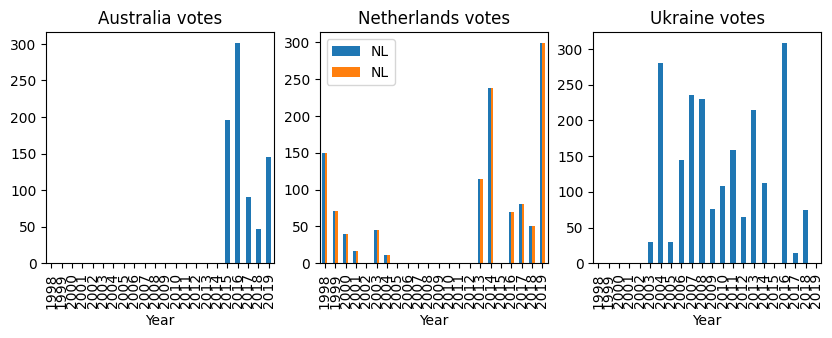

In [43]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

df_all['AU'].groupby('Year').sum().plot(kind='bar', ax=ax1)
df_all['NL'].groupby('Year').sum().plot(kind='bar', ax=ax2)
df_all['UA'].groupby('Year').sum().plot(kind='bar', ax=ax3)
ax1.set_title('Australia votes')
ax2.set_title('Netherlands votes')
ax3.set_title('Ukraine votes')

plt.show()

All looks good. Its easier to work in long rather than wide format, so lets convert the data to long.

In [44]:
df_votes = df_all.stack(dropna=False).reset_index()
df_votes.columns = ['Year', 'From country', 'To country', 'Votes']
df_votes.head()

,Year,From country,To country,Votes
0,1998,BE,AD,NaN
1,1998,BE,AL,NaN
2,1998,BE,AM,NaN
3,1998,BE,AT,NaN
4,1998,BE,AU,NaN


## Adding song and artist data

Votes are cast for songs and artists so we also need some information about the songs each country performed. We will use [this kaggle dataset](https://www.kaggle.com/datasets/minitree/eurovision-song-lyrics) to extract song and artist information and add it to our voting data.

The data is in [json](https://en.wikipedia.org/wiki/JSON) format so lets load it in and have a look.

In [45]:
df_lyrics = pd.read_json(DATAPATH / "eurovision-lyrics-2022.json", orient = "index")
df_lyrics.head()

,#,Country,#.1,Artist,Song,Language,Pl.,Sc.,Eurovision_Number,Year,Host_Country,Host_City,Lyrics,Lyrics translation
0,1,Netherlands,1,Jetty Paerl,De vogels van Holland,Dutch,-,-,1,1956,Switzerland,Lugano,De vogels van Holland zijn zo muzikaal\nZe ler...,The birds of Holland are so musical\nThey alre...
1,2,Switzerland,1,Lys Assia,Das alte Karussell,German,-,-,1,1956,Switzerland,Lugano,Das alte Karussell\nDas geht nicht mehr so sch...,The old carousel\nIt doesn't go as fast anymor...
2,3,Belgium,1,Fud Leclerc,Messieurs les noyés de la Seine,French,-,-,1,1956,Switzerland,Lugano,Messieurs les noyés de la Seine\nOuvrez-moi le...,Ye drowned men of the river Seine (1)\nOpen th...
3,4,Germany (West),1,Walter Andreas Schwarz,Im Wartesaal zum großen Glück,German,-,-,1,1956,Switzerland,Lugano,Es gibt einen Hafen\nDa fährt kaum ein Schiff\...,There is a harbour\nWhere hardly any ship leav...
4,5,France,1,Mathé Altéry,Le temps perdu,French,-,-,1,1956,Switzerland,Lugano,"Chante, carillon\nLe chant du temps perdu\nCha...","Sing, carillon\nThe song of lost time\nSing yo..."


Lets first add some country codes to this data so we can merge relevant columns into the votes. To do this we need to reduce the data to the relevant years and tidy up the country names just like we did for the votes data.

In [46]:
# reduce data to post 1997
mask = (df_lyrics['Year'] > 1997)
df_lyrics = df_lyrics.loc[mask].reset_index()

In [47]:
# tidy country names: fix typos, fill whitespace, rename
df_lyrics["Country"] = df_lyrics["Country"].str.lower()

# make some name replacements
df_lyrics.loc[(df_lyrics['Country'] == "macedonia"), "Country"] = "north macedonia"

# get country code
df_lyrics["Country_Code"] = [country_codes_dict[x] for x in df_lyrics["Country"].str.lower()]

We only really need the Artist name and Language columns added to our votes data, so lets merge them into the votes data `df_votes`. 

In [49]:

# Subset columns
df_lyrics_tomerge = df_lyrics[["Artist", "Year", "Country_Code", "Language"]]

# Merge datasets
df_votes = df_votes.merge(
    df_lyrics_tomerge,
    how="left",
    left_on=["Year", "To country"],
    right_on=["Year", "Country_Code"]
).drop(columns=["Country_Code"])

df_votes.head()

,Year,From country,To country,Votes,Artist,Language
0,1998,BE,AD,NaN,NaN,NaN
1,1998,BE,AL,NaN,NaN,NaN
2,1998,BE,AM,NaN,NaN,NaN
3,1998,BE,AT,NaN,NaN,NaN
4,1998,BE,AU,NaN,NaN,NaN


Note that some of these countries have NaN for Artist in some years, indicating they voted but did not have an artist in the finals. 

Now we have the song and artist data we can use it to search for other variables that may influence voting, such as the gender of the performing artist or the whether the song lyrics are in the voting countries language.

### Gender

To get the gender of the artist performing we can explore [wikidata](https://www.wikidata.org/wiki/Wikidata:Main_Page) by building a query which uses the artist name to find an entry for their gender in wikipedia data, or tells us if they are a group.

To search wikidata we will use the [wikipeople](https://pypi.org/project/wikipeople/) package. 

TODO: Add get_gender code breakdown and walk through. 